In [133]:
import pandas as pd
import pickle
import rdkit.Chem as Chem
from rdkit.Chem import BRICS,Recap, rdFMCS
from rdkit.Chem import Draw
from rdkit import RDLogger
from rdkit.Chem.MolStandardize import rdMolStandardize

RDLogger.DisableLog('rdApp.*')

import math
import numpy as np

from pdbeccdutils.core.models import ParityResult
from pdbeccdutils.computations.parity_method import compare_molecules
from pdbeccdutils.helpers.mol_tools import fix_molecule

import random

import matplotlib.pyplot as plt
import seaborn as sns
#!pip install scikit-learn
from sklearn.metrics import roc_curve, roc_auc_score, auc
import os
#mkae a sanitisation function

def pdbe_sanitise_smiles(smiles, return_mol = False, return_sanitisation = False):
    """
    Sanitises a smiles string using pdbeccdutils fix_molecule functions and
    returns a canonical smiles string or RDKit molecule object. Requires that
    smiles string can be loaded into an RDKit molecule object - returns none if
    this is not possible.
    """
    try:
        mol = Chem.MolFromSmiles(Chem.CanonSmiles(smiles))
    except:
        if return_sanitisation:
            return None, None
        else:
            return None
    
    sanitisation = fix_molecule(mol)
    if sanitisation:
        if return_mol:
            if return_sanitisation:
                return mol, sanitisation
            else:
                return mol
        else:
            sanitised_smiles = Chem.CanonSmiles(Chem.MolToSmiles(mol))
            if return_sanitisation:
                return sanitised_smiles, sanitisation
            else:
                return sanitised_smiles
    else:
        sanitised_smiles = None
        if return_sanitisation:
            return sanitised_smiles, sanitisation
        else:
            return sanitised_smiles

In [134]:
def score_random_pairs(row):
    try:
        mol1, mol1_sanitisation = pdbe_sanitise_smiles(row.descriptor, return_mol = True, return_sanitisation = True)
        mol2, mol2_sanitisation = pdbe_sanitise_smiles(row.canonical_smiles, return_mol = True, return_sanitisation = True)
    except:
        mol1_sanitisation = False
        mol2_sanitisation = False
    if mol1_sanitisation and mol2_sanitisation:
        parity = compare_molecules(mol1, mol2, thresh = 0.1)
        parity_score = parity.similarity_score
        parity_match = parity.mapping
    else:
        print("sanitisation failed")
        parity_score = 0
        parity_match = None
    return parity_score

def get_cognate_score(row, cognate_ligands_df, parity_df):
    cognate_ligand_smiles = cognate_ligands_df.loc[cognate_ligands_df.uniqueID == row.biological_ligand_uniqueID].canonical_smiles.values[0]
    return parity_df.loc[(parity_df.pdb_ligand == row.ligand_uniqueID) & (parity_df.compound == cognate_ligand_smiles)].score.values[0]

def check_ec_lists(row):
    return any(item in row['ec_list'] for item in row['entry'])

In [136]:
bound_entities_to_score = pd.read_pickle("../latest2/pdbe_graph_data/bound_entities_to_score.pkl")

In [137]:
cognate_ligands = pd.read_pickle("../latest2/cognate_ligands/biological_ligands_df.pkl")
cognate_ligands_grouped =  cognate_ligands.groupby(["canonical_smiles", "uniqueID"]).agg({"entry": set}).reset_index()

bound_entities = pd.read_pickle("../latest2/pdbe_graph_data/bound_entities_to_score.pkl")
bound_entities["ec_list"] = bound_entities["ec_list"].str.join(",").str.split(",")

In [139]:
if not os.path.exists("cognate_ligand_pairs_score.pkl"):
    cognate_ligand_pairs = pd.read_csv("cognate_ligand_pairs.csv")
    parity_calcs = pd.read_pickle("../latest2/bound_entities_parity/all_parity_calcs.pkl")
    cognate_ligand_pairs["parityScore"] = cognate_ligand_pairs.apply(lambda x: get_cognate_score(x, cognate_ligands, parity_calcs), axis = 1)
    cognate_ligand_pairs["type"] = "Cognate"

    cognate_ligand_pairs.to_pickle("cognate_ligand_pairs_score.pkl")
else:
    cognate_ligand_pairs = pd.read_pickle("cognate_ligand_pairs_score.pkl")

In [140]:
if not os.path.exists("random_parity_scores_matched.pkl"):
    cognate_ligands = pd.read_pickle("../latest2/cognate_ligands/biological_ligands_df.pkl")
    cognate_ligands_grouped =  cognate_ligands.groupby(["canonical_smiles", "uniqueID"]).agg({"entry": set}).reset_index()

    bound_entities = pd.read_pickle("../latest2/pdbe_graph_data/bound_entities_to_score.pkl")
    bound_entities["ec_list"] = bound_entities["ec_list"].str.join(",").str.split(",")
    
    random_parity_scores_matched = pd.DataFrame()
    to_match = len(cognate_ligand_pairs)
    shuffle_state = 1 
    while len(random_parity_scores_matched) < len(cognate_ligand_pairs):
        random_pdb_ligands_matched = bound_entities.sample(n=len(cognate_ligand_pairs), random_state = 10001)
        random_cognate_ligands_matched = cognate_ligands_grouped.sample(n=len(cognate_ligand_pairs), random_state = 10001)

        combined = pd.concat([random_pdb_ligands_matched[["ligand_entity_id", "descriptor", "ec_list"]].reset_index(drop = True), random_cognate_ligands_matched[["canonical_smiles", "uniqueID", "entry"]].rename(columns = {"uniqueID": "cognateUniqueID"}).reset_index(drop = True)], axis = 1)
        random_parity_scores_matched = pd.concat([random_parity_scores_matched, combined])
        random_parity_scores_matched['ec_match'] = random_parity_scores_matched.apply(lambda row: check_ec_lists(row), axis=1)
        random_parity_scores_matched = random_parity_scores_matched.loc[random_parity_scores_matched.ec_match != True]
        to_match -= len(random_parity_scores_matched)
        bound_entities = bound_entities.sample(n = len(bound_entities), random_state = shuffle_state)
        cognate_ligands_grouped = cognate_ligands_grouped.sample(n = len(cognate_ligands_grouped), random_state = shuffle_state)
        shuffle_state += 1
    
    random_parity_scores_matched["parityScore"] = random_parity_scores_matched.apply(lambda x: score_random_pairs(x), axis = 1)
    random_parity_scores_matched["type"] = "Random"
    random_parity_scores_matched.to_pickle("random_parity_scores_matched.pkl")
else:
    random_parity_scores_matched = pd.read_pickle("random_parity_scores_matched.pkl")

In [141]:
if not os.path.exists("random_parity_scores_2k.pkl"):
    cognate_ligands = pd.read_pickle("../latest2/cognate_ligands/biological_ligands_df.pkl")
    cognate_ligands_grouped =  cognate_ligands.groupby(["canonical_smiles", "uniqueID"]).agg({"entry": set}).reset_index()

    bound_entities = pd.read_pickle("../latest2/pdbe_graph_data/bound_entities_to_score.pkl")
    bound_entities["ec_list"] = bound_entities["ec_list"].str.join(",").str.split(",")
    all_random_parity_scores_list = []
    for x in range(0,5):
        random_parity_scores_matched = pd.DataFrame()
        to_match = 2000
        shuffle_state = 1 
        while len(random_parity_scores_matched) < 2000:
            random_pdb_ligands_matched = bound_entities.sample(n=to_match, random_state = 10001)
            random_cognate_ligands_matched = cognate_ligands_grouped.sample(n=to_match, random_state = 10001)

            combined = pd.concat([random_pdb_ligands_matched[["ligand_entity_id", "descriptor", "ec_list"]].reset_index(drop = True), random_cognate_ligands_matched[["canonical_smiles", "uniqueID", "entry"]].rename(columns = {"uniqueID": "cognateUniqueID"}).reset_index(drop = True)], axis = 1)
            random_parity_scores_matched = pd.concat([random_parity_scores_matched, combined])
            random_parity_scores_matched['ec_match'] = random_parity_scores_matched.apply(lambda row: check_ec_lists(row), axis=1)
            random_parity_scores_matched = random_parity_scores_matched.loc[random_parity_scores_matched.ec_match != True]
            
            to_match -= len(random_parity_scores_matched)
            bound_entities = bound_entities.sample(n = len(bound_entities), random_state = shuffle_state)
            cognate_ligands_grouped = cognate_ligands_grouped.sample(n = len(cognate_ligands_grouped), random_state = shuffle_state)
            shuffle_state += 1
        
    
        random_parity_scores_matched["parityScore"] = random_parity_scores_matched.apply(lambda x: score_random_pairs(x), axis = 1)
        random_parity_scores_matched["quantile_95"] = random_parity_scores_matched.parityScore.quantile(0.95)
        random_parity_scores_matched["type"] = "Random"
        random_parity_scores_matched["rep"] = x
        all_random_parity_scores_list.append(random_parity_scores_matched)
    all_random_parity_scores = pd.concat(all_random_parity_scores_list)
    all_random_parity_scores.to_pickle("random_parity_scores_2k.pkl")
else:
    all_random_parity_scores = pd.read_pickle("random_parity_scores_2k.pkl")

In [142]:
all_random_parity_scores.quantile_95.mean()

#plot a violin plot of the 5 scores and report the 99.9 quantile 
#also do a 99.9 quantile of all data e.g. 10k pairs including potential duplicates
#establish number of duplicate uniqueid pairs in the dataset??
#plot all kde distributions on one plot ? 

0.30006868850639073

<Axes: ylabel='quantile_95'>

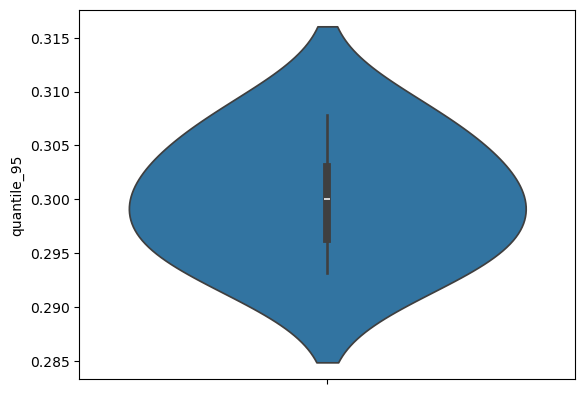

In [143]:
sns.violinplot(y = "quantile_95", data = all_random_parity_scores.groupby("rep").agg({"quantile_95":"first"}).reset_index())

In [144]:
print(f"Average Cognate Parity Score: {cognate_ligand_pairs.parityScore.mean()}")
print(f"Average Random Parity Score (matched distribution): {random_parity_scores_matched.parityScore.mean()}")
print(f"Random Parity Score (matched distribution) 95th Percentile: {random_parity_scores_matched.parityScore.quantile(0.95)}")
print(f"Mean Random Parity Score (2k sample size) 95th Percentile: {all_random_parity_scores.quantile_95.mean()}")

Average Cognate Parity Score: 0.855088228643021
Average Random Parity Score (matched distribution): 0.1541427046214499
Random Parity Score (matched distribution) 95th Percentile: 0.32643678160919537
Mean Random Parity Score (2k sample size) 95th Percentile: 0.30006868850639073


In [145]:
quantile_scores = []
for x in range(0,5):
    quantile_scores.append(all_random_parity_scores.loc[all_random_parity_scores.rep == x].parityScore.quantile(0.999))
sum(quantile_scores)/len(quantile_scores)

0.6356312663806877

In [146]:
combined_scores_df = pd.concat([cognate_ligand_pairs[["parityScore", "type"]], random_parity_scores_matched[["parityScore", "type"]]], axis = 0)

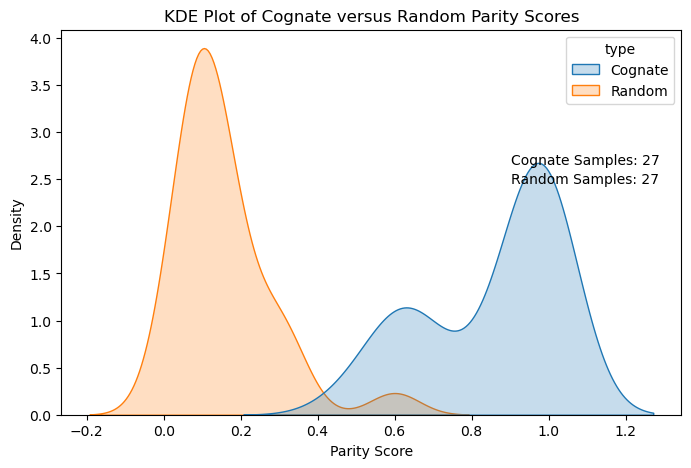

In [147]:
plt.figure(figsize=(8, 5))
sns.kdeplot(combined_scores_df, x = "parityScore", hue = "type", fill=True, common_norm = False, legend = True)
plt.xlabel('Parity Score')
plt.ylabel('Density')
#plt.legend(loc='upper right')
plt.title('KDE Plot of Cognate versus Random Parity Scores')
plt.text(0.725, 0.65, f'Cognate Samples: {len(combined_scores_df.loc[combined_scores_df.type == "Cognate"])}', transform=plt.gca().transAxes)
plt.text(0.725, 0.60, f'Random Samples: {len(combined_scores_df.loc[combined_scores_df.type == "Random"])}', transform=plt.gca().transAxes)
plt.savefig("parity_kde.png")

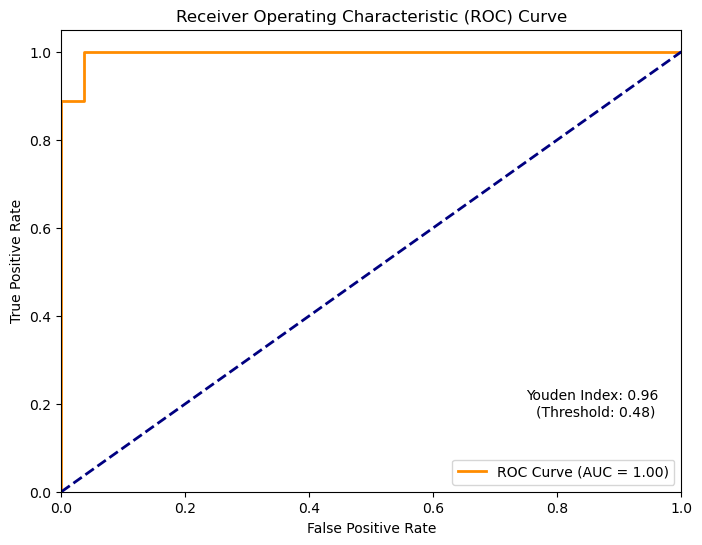

In [148]:
positive_scores = combined_scores_df.loc[combined_scores_df.type == "Cognate"].parityScore.values.tolist()
negative_scores = combined_scores_df.loc[combined_scores_df.type == "Random"].parityScore.values.tolist()

fpr, tpr, thresholds = roc_curve([1] * len(positive_scores) + [0] * len(negative_scores), positive_scores + negative_scores)

roc_auc = roc_auc_score([1] * len(positive_scores) + [0] * len(negative_scores), positive_scores + negative_scores)

youden_threshold = thresholds[np.argmax(tpr - fpr)]
youden_index = np.max(tpr - fpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.text(0.75, 0.20, f'Youden Index: {youden_index:.2f}', transform=plt.gca().transAxes)
plt.text(0.765, 0.165, f'(Threshold: {youden_threshold:.2f})', transform=plt.gca().transAxes)
plt.savefig("parity_roc.png")

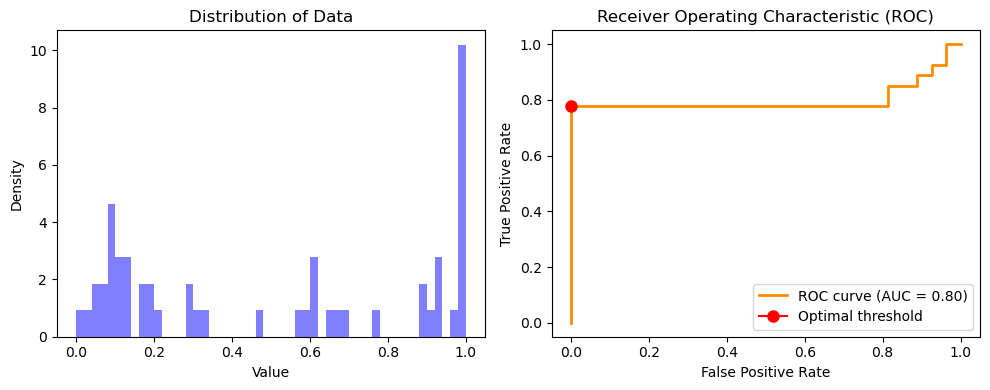

Optimal threshold: 0.1425084431188536


In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_curve, auc

positive_scores = combined_scores_df.loc[combined_scores_df.type == "Cognate"].parityScore.values.tolist()
negative_scores = combined_scores_df.loc[combined_scores_df.type == "Random"].parityScore.values.tolist()

np.random.seed(0)
data = np.concatenate([positive_scores, negative_scores])

gmm = GaussianMixture(n_components=2)
gmm.fit(data.reshape(-1, 1))

# Evaluate likelihoods under the model
likelihoods = gmm.score_samples(data.reshape(-1, 1))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(np.zeros(len(negative_scores)).tolist() + np.ones(len(positive_scores)).tolist(), likelihoods)
roc_auc = auc(fpr, tpr)

# Determine cutoff threshold (e.g., maximizing Youden Index)
youden_index = tpr - fpr
optimal_threshold = thresholds[np.argmax(youden_index)]

# Plot distribution and ROC curve
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(data, bins=50, density=True, alpha=0.5, color='b')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution of Data')

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr[np.argmax(youden_index)], tpr[np.argmax(youden_index)], marker='o', markersize=8, label='Optimal threshold', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f'Optimal threshold: {optimal_threshold}')

In [541]:
thresholds[np.argmax(youden_index)]

0.1272132817968564

In [ ]:
ligands_with_score = parity_calcs.loc[(parity_calcs.compound.isna() == False)]
ligands_missing_score = parity_calcs.loc[(parity_calcs.compound.isna() == Fal) & (parity_calcs.ligand_entity_id.isin(ligands_with_score.ligand_entity_id.unique()) == False)]

ligands_with_score.reset_index().pdb_ligand.value_counts()

ligands_with_score.pdb_ligand.nunique() + ligands_missing_score.pdb_ligand.nunique()
ligands_max_score = ligands_with_score.reset_index(drop = True).iloc[ligands_with_score.reset_index(drop = True).groupby("pdb_ligand")["score"].idxmax()]

max_scores = ligands_with_score.groupby('ligand_entity_id')['score'].max()

plt.hist(max_scores, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Histogram of Parity Scores for PDB-ligand Cognate Ligand')
plt.show()

In [303]:
parity_max_ec_ligand_pairs = parity_calcs.groupby(["ec", "pdb_ligand"]).agg({"score":"max"}).reset_index()

In [305]:
parity_max_ec_ligand_pairs.loc[parity_max_ec_ligand_pairs.score > 0.55]

,ec,pdb_ligand,score
13,1.1.1.1,3042.0,0.571429
25,1.1.1.1,6187.0,0.645161
30,1.1.1.1,7740.0,0.777778
31,1.1.1.1,7741.0,0.777778
39,1.1.1.1,9854.0,0.692308
...,...,...,...
1554335,7.5.2.8,23682.0,0.571429
1554338,7.5.2.8,26043.0,0.833333
1554477,7.6.2.11,23279.0,0.714286
1554684,7.6.2.4,13969.0,0.694444


In [297]:
parity_calcs.loc[(parity_calcs.compound.isna() == True)]

,ec,pdb_ligand,pdb_ligand_name,pdb_ligand_description,compound,score,error,cancelled,pdbl_subparity,bl_subparity


In [166]:
scop = pd.read_csv("../../ProCogGraphData/procoggraph_20240401/pdbe_graph_data/scop_pdb_residue_interactions.csv.gz")
scop.columns
scop_mean_domain_perc = scop[["uniqueID", "domain_contact_perc", "scop_id"]].groupby("uniqueID").agg({"domain_contact_perc": "mean", "scop_id": "nunique"})
#scop_mean_domain_perc.loc[scop_mean_domain_perc.domain_contact_perc <= 0.3].scop_id.max()
#scop_mean_domain_perc.loc[scop_mean_domain_perc.scop_id == 4, "domain_contact_perc"].mean()
#scop[["uniqueID", "scop_id"]].groupby("uniqueID").agg({"scop_id": "nunique"}).reset_index().scop_id.max()

sns.kdeplot(data = scop_mean_domain_perc, x = "domain_contact_perc")
sns.kdeplot(data = scop_mean_domain_perc, x = "domain_contact_perc", y = "scop_id")

/tmp/ipykernel_3668372/2007911768.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  scop = pd.read_csv("../../ProCogGraphData/procoggraph_20240401/pdbe_graph_data/scop_pdb_residue_interactions.csv.gz")


Index(['pdb_id', 'pdb_descriptor', 'pdb_title', 'pdb_keywords',
       'protein_entity_id', 'protein_entity_description', 'chainUniqueID',
       'chain_id', 'auth_chain_id', 'ligand_entity_id',
       'ligand_entity_id_numerical', 'description', 'bound_ligand_id',
       'bound_ligand_name', 'name', 'bound_ligand_struct_asym_id', 'type',
       'descriptor', 'scop_sunid', 'scop_description', 'scop_sccs',
       'scop_class_id', 'scop_fold_id', 'scop_superfamily_id', 'scop_id',
       'scop_chain', 'uniqueID', 'bm_ids', 'bound_molecule_display_id',
       'pdb_residue_auth_id', 'bound_ligand_auth_id', 'hbond_count',
       'covalent_count', 'contact_type_count', 'uniprot_accession',
       'protein_entity_ec', 'ec_list', 'sccs', 'domain_sunid',
       'ancestor_sunid', 'cl_id', 'cf_id', 'sf_id', 'fa_id', 'dm_id', 'sp_id',
       'px_id', 'cl_description', 'cf_description', 'sf_description',
       'fa_description', 'dm_description', 'sp_description', 'px_description',
       'total_con

6

0.25

6

<Axes: xlabel='domain_contact_perc', ylabel='Density'>

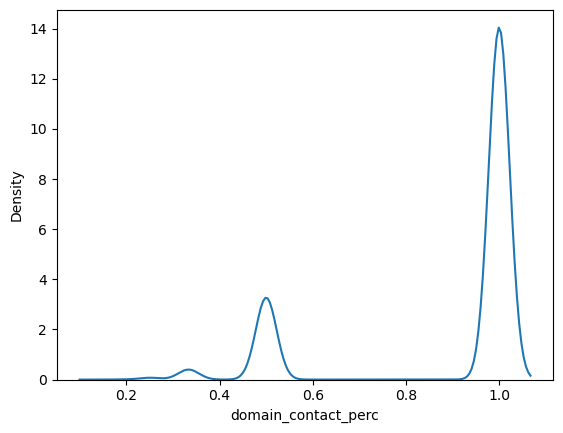

<Axes: xlabel='domain_contact_perc', ylabel='scop_id'>

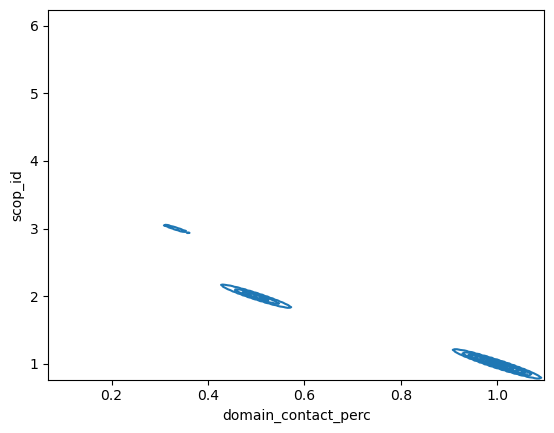